In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

In [2]:
class CliffWalkingEnv:
    def __init__(self, nrow, ncol):
        self.nrow = nrow
        self.ncol  = ncol

        # curent agent position
        self.x = 0
        self.y = self.ncol-1

    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        
        reward = -1  # f(next_state)
        
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            # 如果不是在终点的话奖励为-100，如果到了终点，虽然奖励还是-1，但是就可以停止了，不用增加负奖励了，因此也是agent喜欢的地方
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):
        self.x = 0
        self.y = self.nrow-1
        # one-dimension pos
        return self.y * self.ncol+self.x

In [3]:
class Sarsa:
    # the kernel of Sarsa is time-diff
    # that is calculate q(sa) plus，so need to maintain a Q(s, a) table
    # q(s, a) += alpha(r + gemma*q(s', a')-q(s,a))  # if have many action use greedy
    
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        # 这里用np初始化，便于调用argmax等接口
        self.Q_table = np.zeros([nrow * ncol, n_action])  
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    # 选取下一步的操作,具体实现为epsilon-贪婪
    def take_action(self, state):  
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  
        # 输入 state,返回最大值对应的动作
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    # sarsa 核心函数
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3043.41it/s, episode=500, return=-18.900]


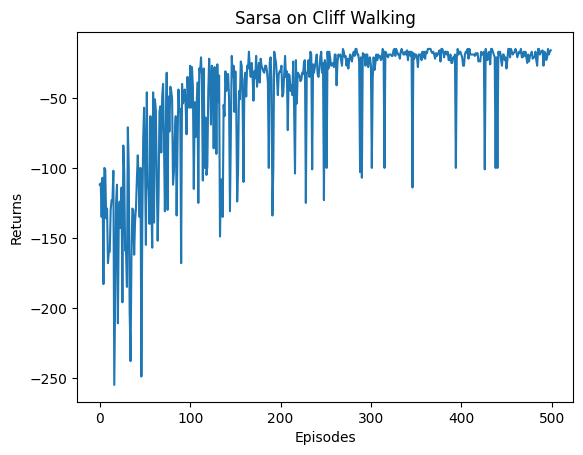

In [4]:
# run

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol=ncol, nrow=nrow)
np.random.seed(0)
alpha = 0.1
episilon = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, episilon, alpha, gamma)
num_episodes=500

return_list = []  # ???

for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' %i) as pbar:
        # 每个子场景
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            # init state and get action
            state = env.reset()
            action = agent.take_action(state)
            done=False

            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            
            if(i_episode+1)%10==0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
            
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [5]:
# 横坐标：episode；纵坐标：整个episode的奖励值

In [6]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# 我们可以发现，如果greedy=0，即采取完全的贪心策略，模型最终收敛的有问题，在原点采取向上的非法动作，如果增加随机0.1则可以解决这个问题，也可以用greedy-decay

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [7]:
agent.Q_table

array([[ -7.59577977,  -7.62436847,  -7.61633964,  -7.59531185],
       [ -7.38974254,  -7.39490644,  -7.38946063,  -7.36589515],
       [ -7.1294928 ,  -7.11474945,  -7.11111298,  -7.10594277],
       [ -6.81856491,  -6.81659914,  -6.85624081,  -6.81177945],
       [ -6.50063904,  -6.48823138,  -6.55854321,  -6.4846527 ],
       [ -6.17724439,  -6.12539257,  -6.22408759,  -6.11068391],
       [ -5.77083556,  -5.72138029,  -5.93216275,  -5.69039784],
       [ -5.27141661,  -5.24526745,  -5.34931226,  -5.23441716],
       [ -4.81105888,  -4.72925613,  -4.80391638,  -4.72325765],
       [ -4.21539556,  -4.1630529 ,  -4.4933396 ,  -4.15930985],
       [ -3.5964426 ,  -3.54485655,  -3.7672846 ,  -3.54108457],
       [ -2.9655844 ,  -2.81596464,  -2.9060681 ,  -2.92198515],
       [ -7.79766137,  -7.81512283,  -7.83318019,  -7.75851027],
       [ -7.52126433,  -7.98223998,  -7.66279159,  -7.43958238],
       [ -7.16929253,  -8.17881075,  -7.21507136,  -7.12736215],
       [ -6.92609788,  -7